# Problem 2 - Generative Adversarial Networks continue... Contains part 3

In [1]:
import pandas as pd
import numpy as np
import string
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import time

In [2]:
# Prepare torch gpu
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Using GPU device
gpu_device = torch.device("cuda:0")

True
Tesla K80


### Loading data into tensor

In [3]:
# Transform to tensors
fmnist_transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# Loading the training data for use
fmnist = datasets.FashionMNIST(root="./fashion_mnist", train = True, transform = fmnist_transform, download = True)
data_loader = DataLoader(dataset = fmnist, batch_size = 16, shuffle = True, num_workers = 0)

# Load test data
test_fmnist = datasets.FashionMNIST(root="./fashion_mnist", train = False, transform = fmnist_transform, download = True)
test_data_loader = DataLoader(dataset = test_fmnist, batch_size = 16, shuffle = True, num_workers = 0)

In [5]:
# Create reverse dictionary
reverse_lookup = {x:y for y,x in data_loader.dataset.class_to_idx.items()}

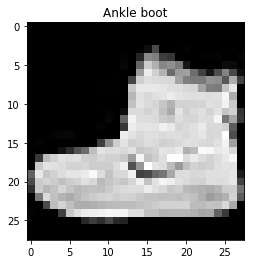

In [6]:
# Plotting the first example to see
_ = plt.imshow(data_loader.dataset.data[0], "gray")
_ = plt.title(reverse_lookup[data_loader.dataset.targets[0].detach().numpy().item()])

In [7]:
reverse_lookup

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
def show_images(torch_gpu_tensors):
    fig = plt.figure(figsize=(14,14))
    for i in range(20):
        p = i + 1
        axes = fig.add_subplot(5,4,p)
        plt.imshow(convert_d(torch_gpu_tensors, "1>2")[i].cpu().detach().numpy(), "gray")
    plt.show()

In [9]:
def show_images_with_pred(torch_gpu_tensors, dis_model):
    fig = plt.figure(figsize=(14,18))
    for i in range(20):
        p = i + 1
        axes = fig.add_subplot(5,4,p)
        
        dis_pred = reverse_lookup[vanilla_dis_model.predict(torch_gpu_tensors).cpu().numpy()[i]]
        
        plt.imshow(convert_d(torch_gpu_tensors, "1>2")[i].cpu().detach().numpy(), "gray")
        
        axes.set_title(dis_pred)
    plt.show()

In [10]:
# Convert from 2d to 1d and 1d to 2d
def convert_d(inputs, mode):
    if mode == "2>1":
        return inputs.view(inputs.size(0), 784)
    elif mode == "1>2":
        return inputs.view(inputs.size(0), 28, 28)
    else:
        return None

In [11]:
# Function to generate random noise
def random_noise(n):
    return torch.randn((n, 32))

## Part 3 - Mode Collapse in GANs (10 points)

In [12]:
# The vannila generator with 3 hidden layers and 1 output layer
class vanilla_gen(nn.Module):
    def __init__(self):
        super(vanilla_gen, self).__init__()
        # Input the noise with 64 values
        self.hidden1 = nn.Sequential(nn.Linear(32, 64), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(64, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(512, 784), nn.Tanh())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [13]:
# The discriminator for the vannila gan
class vanilla_dis(nn.Module):
    def __init__(self):
        super(vanilla_dis, self).__init__()
        # Input the image with 784
        self.hidden1 = nn.Sequential(nn.Linear(784, 512), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [14]:
# Load model from Question 2 part 1
vanilla_gen_model = vanilla_gen()
vanilla_gen_model.load_state_dict(torch.load("./vanilla_gen.pth"))
vanilla_gen_model.to(gpu_device)
vanilla_dis_model = vanilla_dis()
vanilla_dis_model.load_state_dict(torch.load("./vanilla_dis.pth"))

# Changing the final output layer of the model to 10 channels
vanilla_dis_model.output_layer = nn.Sequential(nn.Linear(64, 10))
vanilla_dis_model.to(gpu_device)

# Set the criterion
re_train_cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
re_train_sgd = optim.Adam(vanilla_dis_model.parameters(), lr = 0.0001)

### Take a copy of your vanilla GAN discriminator and change its output channel from 1 output to 10 output units. Fine-tune it as a classifier on the Fashion-MNIST training set.

In [15]:
# Re-train the discriminator funciton for 10 outputs
def train_re_dis(dis_model, dataloader_train, dataloader_test, dis_optimizer, criterion, num_epochs):    
    # Run all the epochs
    all_train_acc = []
    all_train_loss = []
    all_test_acc = []
    all_test_loss = []
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dataset_sizes = {"train" : len(dataloader_train.dataset.data), "test" : len(dataloader_test.dataset.data)}
        if (epoch + 1) % 1 == 0:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
        for stage in ['train', 'test']:
            if stage == 'train':
                dis_model.train()
                data_loader = dataloader_train
            else:
                dis_model.eval()
                data_loader = dataloader_test
                
            run_correct = 0
            run_loss = 0.0
            
            # Load data from dataloader
            for i, data in enumerate(data_loader, 0):
                inputs_raw, labels = data[0].to(gpu_device), data[1].to(gpu_device)
                inputs = Variable(convert_d(inputs_raw, "2>1")).to(gpu_device)
                
                if stage == 'train':
                    dis_optimizer.zero_grad()
                    # Train with real data
                    p = dis_model(inputs)
                    _, preds = torch.max(p, 1)
                    loss = criterion(p, labels)
                    loss.backward()

                    dis_optimizer.step()
                else:
                    with torch.no_grad():
                        p = dis_model(inputs)
                        _, preds = torch.max(p, 1)
                        loss = criterion(p, labels)

                # Add to loss and accuracy
                run_correct += torch.sum(preds == labels)
                run_loss += loss.item()

            epoch_acc = run_correct.item() / dataset_sizes[stage]
            epoch_loss = run_loss / dataset_sizes[stage]
            
            if stage == 'train':
                all_train_acc.append(epoch_acc)
                all_train_loss.append(epoch_loss)
            else:
                all_test_acc.append(epoch_acc)
                all_test_loss.append(epoch_loss)

            if (epoch + 1) % 1 == 0:
                print(stage, "---", 'Accuracy: %.3f  Loss: %.3f' % (epoch_acc,  epoch_loss))

            run_loss = 0.0
            run_correct = 0
            
    return all_train_acc, all_train_loss, all_test_acc, all_test_loss

In [16]:
re_train_acc, re_train_loss, re_test_acc, re_test_loss = train_re_dis(vanilla_dis_model, data_loader,
                                                                      test_data_loader, re_train_sgd,
                                                                      re_train_cross_entro, 5)

Epoch 1 / 5
train --- Accuracy: 0.811  Loss: 0.033
test --- Accuracy: 0.849  Loss: 0.026
Epoch 2 / 5
train --- Accuracy: 0.869  Loss: 0.022
test --- Accuracy: 0.862  Loss: 0.024
Epoch 3 / 5
train --- Accuracy: 0.883  Loss: 0.020
test --- Accuracy: 0.873  Loss: 0.022
Epoch 4 / 5
train --- Accuracy: 0.891  Loss: 0.018
test --- Accuracy: 0.876  Loss: 0.021
Epoch 5 / 5
train --- Accuracy: 0.899  Loss: 0.017
test --- Accuracy: 0.881  Loss: 0.021


### Now generate 3000 samples using the generator you trained for Part 1.

In [17]:
samples_3000_gen = vanilla_gen_model(random_noise(3000).to(gpu_device)).detach()

### Use the classifier you just trained to predict the class labels of those samples. Plot the histogram of predicted labels.

In [18]:
prediction_3000_dis = vanilla_dis_model.predict(samples_3000_gen)

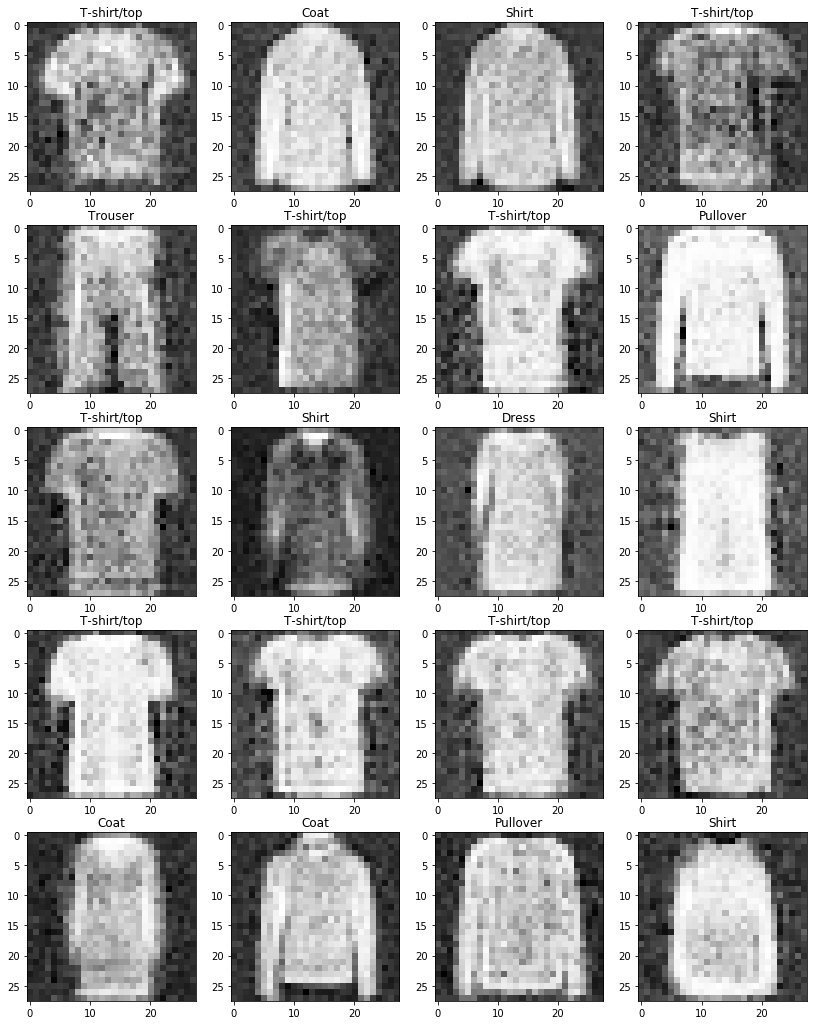

In [19]:
show_images_with_pred(samples_3000_gen[:20], vanilla_dis_model)

In [20]:
np.unique(prediction_3000_dis.cpu().numpy(), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([576,  35, 445, 174, 567,  12, 637,   7, 531,  16]))

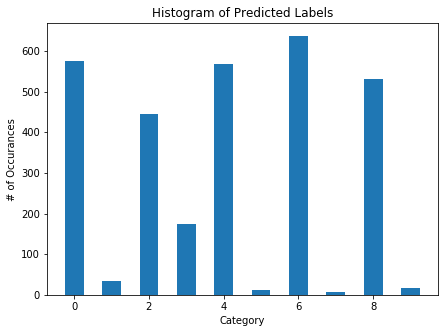

In [21]:
_ = plt.figure(figsize = (7, 5))
_ = plt.hist(prediction_3000_dis.cpu().numpy(), rwidth = 0.5, bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
_ = plt.title("Histogram of Predicted Labels")
_ = plt.xlabel("Category")
_ = plt.ylabel("# of Occurances")
_ = plt.xticks = range(0,9)
_ = plt.show()

The histogram not equally distributed

## Unrolled GAN

In [22]:
# Generator training function
def train_unroll_gen(dis_unroll, gen_optimizer, generated_data):
    gen_optimizer.zero_grad()
    p = dis_unroll(generated_data)
    loss = unroll_loss(p, Variable(torch.ones(generated_data.size(0), 1)).to(gpu_device))
    loss.backward()
    gen_optimizer.step()
    return loss

In [23]:
# Discriminator training funciton
def train_unroll_dis(dis_optimizer, real_data, generated_data):
    dis_optimizer.zero_grad()
    # Train with real data
    p_real = unroll_dis_model(real_data)
    loss_real = unroll_loss(p_real, Variable(torch.ones(real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = unroll_dis_model(generated_data)
    loss_generated = unroll_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    dis_optimizer.step()
    
    return loss_real + loss_generated, p_real, p_gen

In [24]:
# Discriminator training funciton
def train_unroll_step_dis(dis_unroll, unroll_dis_optimizer, u_real_data, generated_data):
    unroll_dis_optimizer.zero_grad()
    # Train with real data
    p_real = dis_unroll(u_real_data)
    loss_real = unroll_loss(p_real, Variable(torch.ones(u_real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = dis_unroll(generated_data)
    loss_generated = unroll_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    unroll_dis_optimizer.step()
    
    return dis_unroll, loss_real + loss_generated

In [25]:
# The training function
def train_unrolled(gen_model, dis_model, dataloader, gen_optimizer, dis_optimizer, unroll_steps, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    all_dis_loss = []
    all_gen_loss = []
    gen_model.train()
    dis_model.train()
    display_epoch = [1, 5, 10, 15, 20]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dis_loss = 0.0
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data = data[0].to(gpu_device)
            real_data = Variable(convert_d(image_data, "2>1")).to(gpu_device)
            # Train Discriminator
            with torch.no_grad():
                generated_data = gen_model(random_noise(real_data.size(0)).to(gpu_device)).detach()
            d_loss, d_p_real, d_p_generated = train_unroll_dis(dis_optimizer, real_data, generated_data)
            
            # Unroll step
            dis_unroll = type(dis_model)()
            dis_unroll.load_state_dict(dis_model.state_dict())
            dis_unroll.to(gpu_device)
            unroll_step_dis_sgd = optim.Adam(dis_unroll.parameters(), lr = 0.0001)
            
            for k, data in enumerate(data_loader, 0):
                if k == unroll_steps:
                    break
                u_image_data = data[0].to(gpu_device)
                u_real_data = Variable(convert_d(u_image_data, "2>1")).to(gpu_device)
                with torch.no_grad():
                    unroll_generated_data = gen_model(random_noise(u_real_data.size(0)).to(gpu_device)).detach()
                dis_unroll, unroll_loss_count = train_unroll_step_dis(dis_unroll, unroll_step_dis_sgd,
                                                                u_real_data, unroll_generated_data)
            
            # Train Genereator
            generated_images = gen_model(random_noise(image_data.size(0)).to(gpu_device))
            g_loss = train_unroll_gen(dis_unroll, gen_optimizer, generated_images)

            # Add to loss and accuracy
            dis_loss += d_loss.item()
            gen_loss += g_loss.item()

        epoch_dis_loss = dis_loss / dataloader.dataset.data.size(0)
        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_dis_loss.append(epoch_dis_loss)
        all_gen_loss.append(epoch_gen_loss)

        if (epoch + 1) in display_epoch:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
            print("Discriminator Loss:", epoch_dis_loss)
            print("Generator Loss:", epoch_gen_loss)
            with torch.no_grad():
                gen_images = gen_model(random_noise(20).to(gpu_device))
            gen_img.append(gen_images)
#             show_images_with_pred(gen_images, vanilla_dis_model)
            
#         # To prevent mode collapse, manually enter ok to continue
#         if (epoch + 1) in [3,5]:
#             with torch.no_grad():
#                 gen_images = gen_model(random_noise(20).to(gpu_device))
#             show_images_with_pred(gen_images, vanilla_dis_model)
#             #input("Please press enter to continue")

        run_loss = 0.0
        run_correct = 0
    
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    return all_dis_loss, all_gen_loss, gen_img

In [26]:
# Set up models and solvers and loss for training
unroll_gen_model = vanilla_gen()
unroll_gen_model.to(gpu_device)

unroll_dis_model = vanilla_dis()
unroll_dis_model.to(gpu_device)

unroll_loss = nn.BCELoss()
unroll_gen_sgd = optim.Adam(unroll_gen_model.parameters(), lr = 0.0003)
unroll_dis_sgd = optim.Adam(unroll_dis_model.parameters(), lr = 0.0001)

In [27]:
unroll_dis_loss, unroll_gen_loss, unroll_gen_pic = train_unrolled(unroll_gen_model, unroll_dis_model,
                                                  data_loader, unroll_gen_sgd, unroll_dis_sgd, 6, 20)

Epoch 1 / 20
Discriminator Loss: 0.07692129032636683
Generator Loss: 0.0707653788536787
Epoch 5 / 20
Discriminator Loss: 0.07973436690171559
Generator Loss: 0.05454360520144304
Epoch 10 / 20
Discriminator Loss: 0.07609586089551448
Generator Loss: 0.05734928272465865
Epoch 15 / 20
Discriminator Loss: 0.07277391137182712
Generator Loss: 0.06057267579038938
Epoch 20 / 20
Discriminator Loss: 0.07144173887968064
Generator Loss: 0.06328138924638431
Total training time is 5703751ms


In [28]:
# Save model
torch.save(unroll_gen_model.state_dict(), "./unroll_gen.pth")
torch.save(unroll_dis_model.state_dict(), "./unroll_dis.pth")

In [29]:
# Save data
store_unroll_loss = pd.DataFrame({"Discriminator_loss": unroll_dis_loss, "Generator_loss": unroll_gen_loss})
store_unroll_loss.to_csv("unroll_result.csv", index = False)
store_unroll_pic = pd.DataFrame(unroll_gen_pic)
store_unroll_pic.to_csv("unroll_pic.csv", index = False)

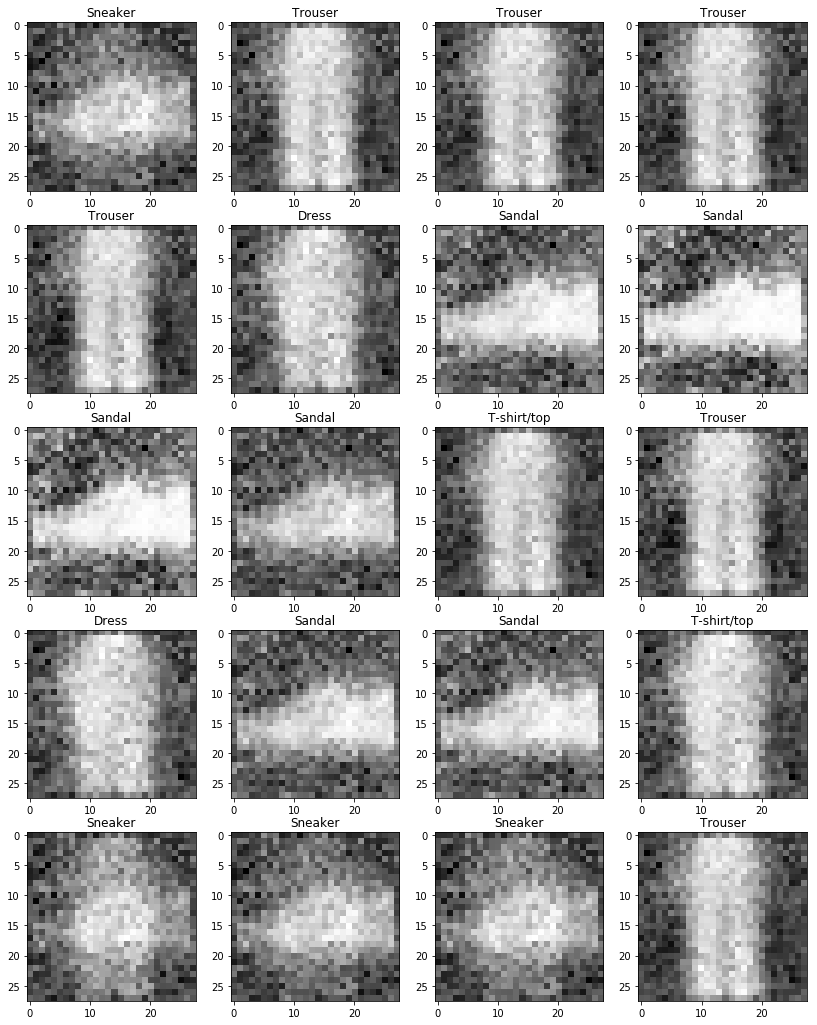

In [30]:
show_images_with_pred(unroll_gen_pic[0], vanilla_dis_model)

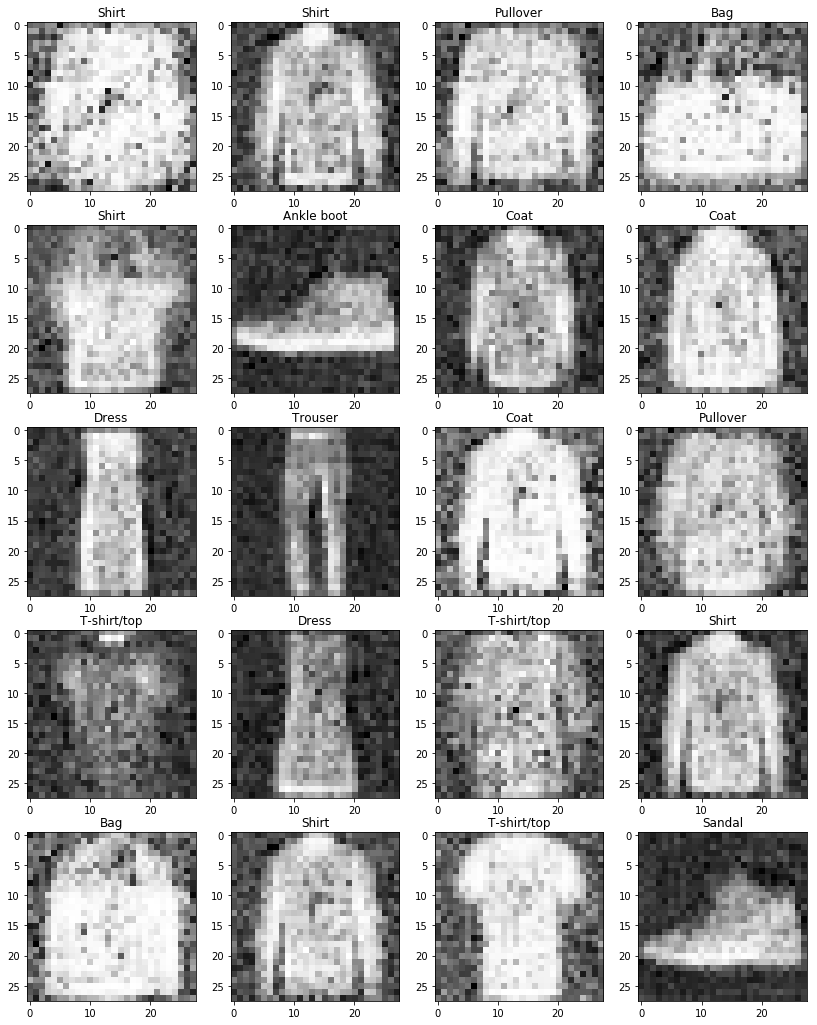

In [31]:
show_images_with_pred(unroll_gen_pic[len(unroll_gen_pic)//2 + 1], vanilla_dis_model)

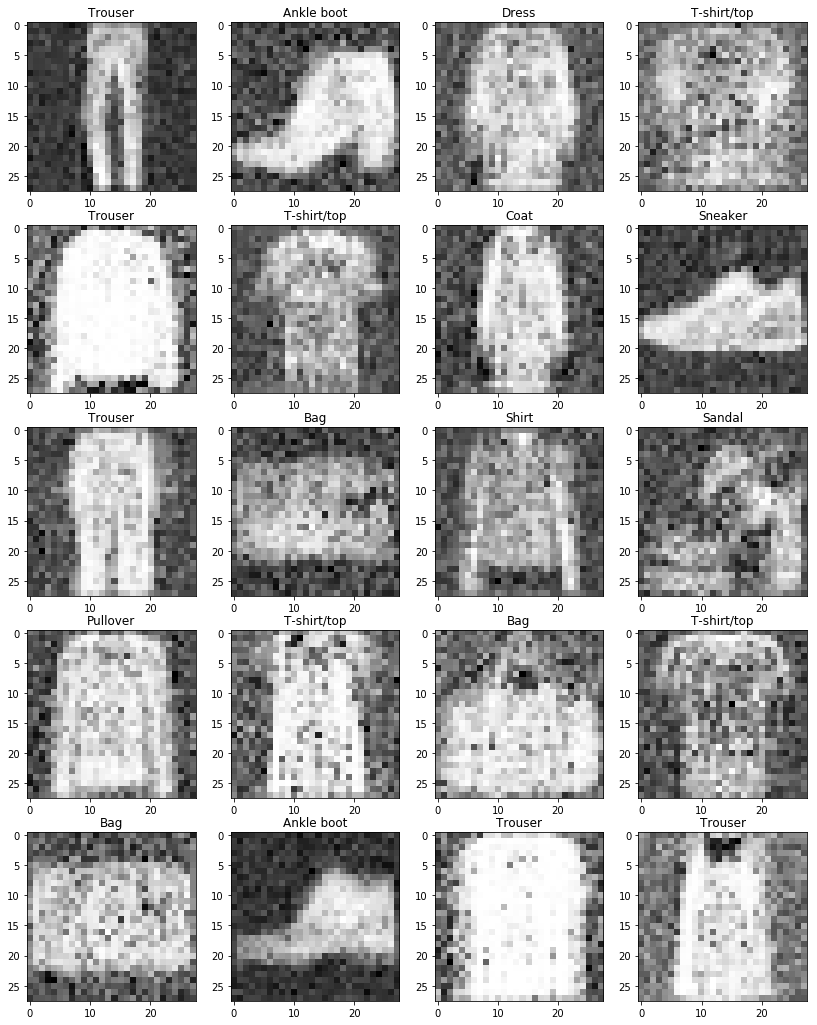

In [32]:
show_images_with_pred(unroll_gen_pic[-1], vanilla_dis_model)

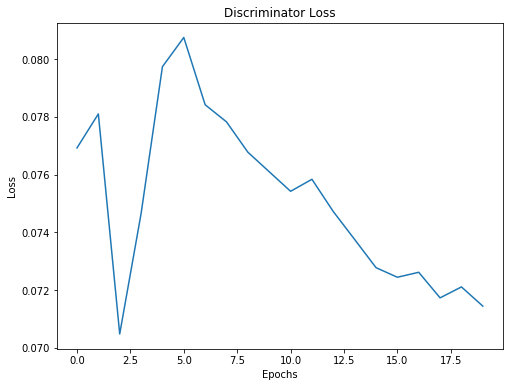

In [33]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(unroll_dis_loss)), unroll_dis_loss)
_ = plt.title("Discriminator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

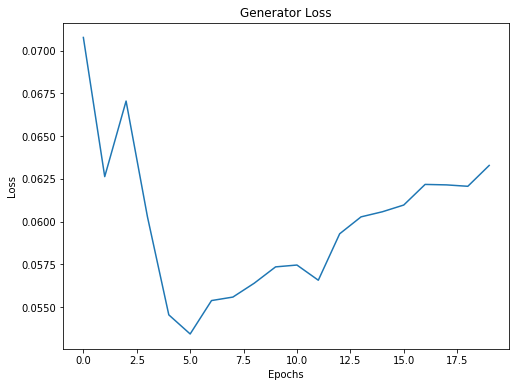

In [34]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(unroll_gen_loss)), unroll_gen_loss)
_ = plt.title("Generator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

### Now generate 3000 samples using the unrolled generator and re-plot the histogram

In [35]:
unrolled_3000_gen = unroll_gen_model(random_noise(3000).to(gpu_device)).detach()

In [36]:
prediction_3000_unrolled = vanilla_dis_model.predict(unrolled_3000_gen)

In [37]:
np.unique(prediction_3000_unrolled.cpu().numpy(), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([452, 288, 432, 196, 446, 197, 308,  73, 409, 199]))

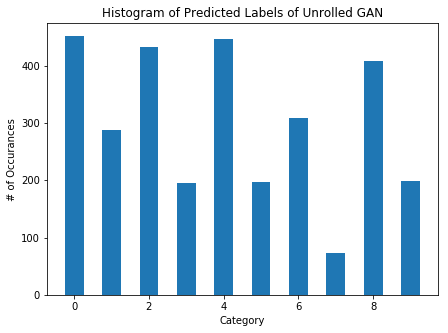

In [38]:
_ = plt.figure(figsize = (7, 5))
_ = plt.hist(prediction_3000_unrolled.cpu().numpy(), rwidth = 0.5, bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
_ = plt.title("Histogram of Predicted Labels of Unrolled GAN")
_ = plt.xlabel("Category")
_ = plt.ylabel("# of Occurances")
_ = plt.xticks = range(0,9)
_ = plt.show()

### WGAN model with c = 0.1

In [39]:
# Load model from part 2
wgan_gen_model = vanilla_gen()
wgan_gen_model.load_state_dict(torch.load("./wgan_gen.pth"))
wgan_gen_model.to(gpu_device)

vanilla_gen(
  (hidden1): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [40]:
wgan_3000_gen = wgan_gen_model(random_noise(3000).to(gpu_device)).detach()

In [41]:
prediction_3000_wgan = vanilla_dis_model.predict(wgan_3000_gen)

In [42]:
np.unique(prediction_3000_wgan.cpu().numpy(), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([233, 604,  20, 107, 510, 326, 219, 461, 224, 296]))

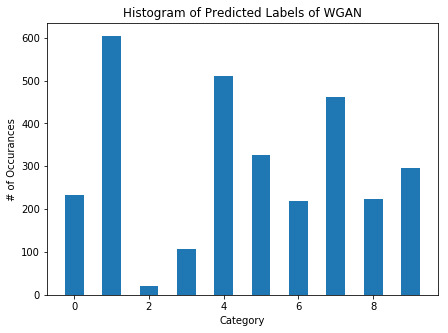

In [43]:
_ = plt.figure(figsize = (7, 5))
_ = plt.hist(prediction_3000_wgan.cpu().numpy(), rwidth = 0.5, bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
_ = plt.title("Histogram of Predicted Labels of WGAN")
_ = plt.xlabel("Category")
_ = plt.ylabel("# of Occurances")
_ = plt.xticks = range(0,9)
_ = plt.show()